In [98]:
import pandas as pd
act = pd.read_csv('../data/dailyActivity_merged_fin_sum.csv')

act

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,3/25/2016,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.00,33,12,205,804,1819
1,1503960366,3/26/2016,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.00,89,17,274,588,2154
2,1503960366,3/27/2016,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.00,56,5,268,605,1944
3,1503960366,3/28/2016,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.00,39,20,224,1080,1932
4,1503960366,3/29/2016,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.00,28,28,243,763,1886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,8877689391,5/5/2016,14055,10.67,10.67,0.0,5.46,0.82,4.37,0.00,67,15,188,1170,3052
1369,8877689391,5/6/2016,21727,19.34,19.34,0.0,12.79,0.29,6.16,0.00,96,17,232,1095,4015
1370,8877689391,5/7/2016,12332,8.13,8.13,0.0,0.08,0.96,6.99,0.00,105,28,271,1036,4142
1371,8877689391,5/8/2016,10686,8.11,8.11,0.0,1.08,0.20,6.80,0.00,17,4,245,1174,2847


In [99]:
act["TotalActiveMinutes"] = (
    act["VeryActiveMinutes"]
    + act["FairlyActiveMinutes"]
    + act["LightlyActiveMinutes"]
)


In [100]:
act["TotalActiveMinutes"]

0       250
1       380
2       329
3       283
4       299
       ... 
1368    270
1369    345
1370    404
1371    266
1372    309
Name: TotalActiveMinutes, Length: 1373, dtype: int64

In [101]:
act.duplicated(subset=["Id", "ActivityDate"]).sum()

np.int64(0)

In [ ]:
act["SedentaryRatio"] = act["SedentaryMinutes"] / 1440 #1440 : 하루 총 1440분.
act["SedentaryRatio"]

0       0.558333
1       0.408333
2       0.420139
3       0.750000
4       0.529861
          ...   
1368    0.812500
1369    0.760417
1370    0.719444
1371    0.815278
1372    0.785417
Name: SedentaryRatio, Length: 1373, dtype: float64

In [103]:
# DayType 분류 (우선순위: Active → Rest(steps=0) → Over-Sedentary → Low Engagement → Normal)
import numpy as np

conditions = [
    (act["TotalSteps"] >= 7000) | (act["TotalActiveMinutes"] >= 60), # Active
    (act["TotalSteps"] == 0), # Rest (Off/No-Data)
    (act["SedentaryRatio"] >= 0.75) & (act["TotalSteps"] > 0), # Over-Sedentary
    (act["TotalSteps"] < 3000) & (act["SedentaryRatio"] >= 0.50) & (act["TotalSteps"] > 0)  # Low Engagement
]

choices = ["Active Day", "Rest Day", "Over-Sedentary Day", "Low Engagement Day"]

act["DayType"] = np.select(conditions, choices, default="Normal Day")

# 확인
act["DayType"].value_counts()

DayType
Active Day            1163
Rest Day               132
Over-Sedentary Day      62
Normal Day               8
Low Engagement Day       8
Name: count, dtype: int64

In [105]:
import pandas as pd

act["ActivityDate"] = pd.to_datetime(act["ActivityDate"]).dt.date   # 날짜만 남김(시간 제거)


In [109]:
daily_counts = (
    act.groupby(["ActivityDate", "DayType"])
       .size()
       .unstack(fill_value=0)
       .sort_index()
)
daily_counts

DayType,Active Day,Low Engagement Day,Normal Day,Over-Sedentary Day,Rest Day
ActivityDate,,,,,
2016-03-12,1,0,0,0,1
2016-03-13,1,0,0,0,1
2016-03-14,2,0,0,0,0
2016-03-15,1,0,0,0,1
2016-03-16,1,0,0,1,0
...,...,...,...,...,...
2016-05-08,23,0,0,0,4
2016-05-09,24,0,0,0,3
2016-05-10,21,1,0,0,4


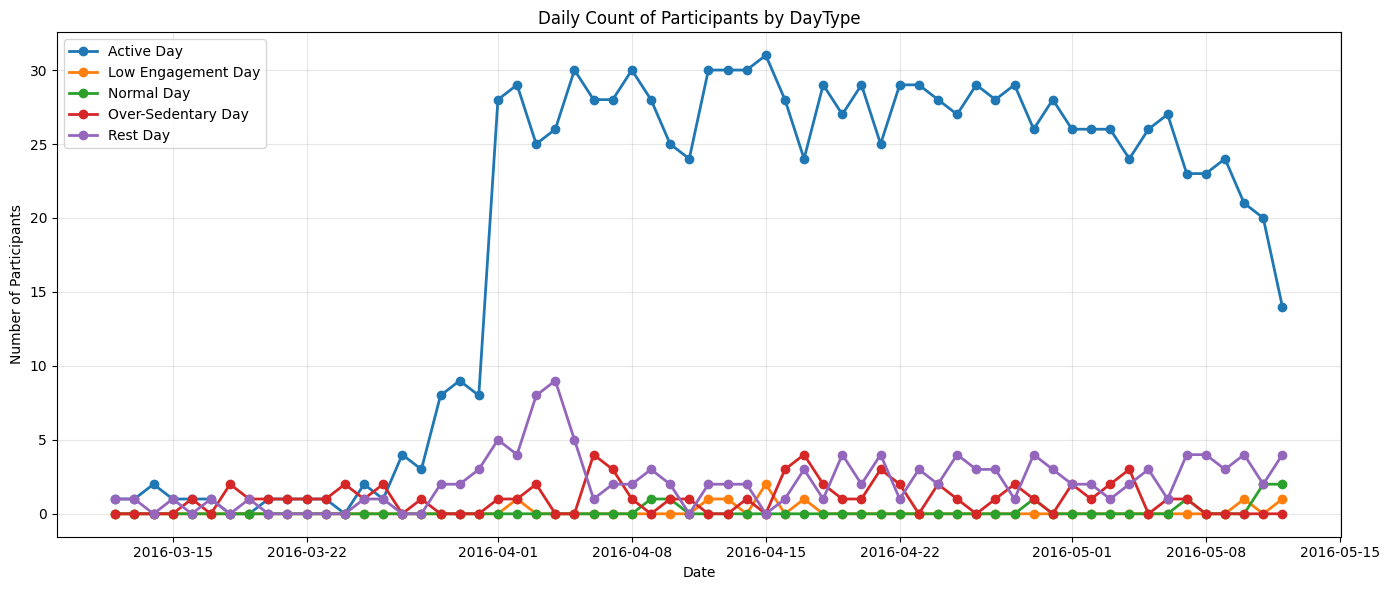

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for daytype in daily_counts.columns:
    plt.plot(
        daily_counts.index,
        daily_counts[daytype],
        marker="o",
        linewidth=2,
        label=daytype
    )
plt.xlabel("Date")
plt.ylabel("Number of Participants")
plt.title("Daily Count of Participants by DayType")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

비즈니스 목표 : 사용자들의 일상 활동 패턴이 시간에 따라 어떻게 변화하는지 파악하고,
               지속 가능한 건강 루틴을 방해하는 지점을 발견해 이를 제품 마케팅 전략으로 세운다.

[그래프를 통해 알 수 있는 사실]
1. 3월까지는 사용자 수가 많지가 않음
2. 3월 말부터 4월 넘어가면서 사용자 급등하기 시작 
         --> 기기 착용 안정화, 참여자 풀의 완성
3. Active 사용자가 많다가 5월부터 서서히 감소
         --> Sedentary/Rest Day의 증가로 연결됨
         --> 행동 피로 누적 or 루틴 붕괴 신호

이러한 패턴은 여성 헬스케어 서비스에서 단기 성과보다 지속 가능한 루틴 설계와 회복 중심 개입이 중요함을 뒷받침한다.